# Shopping Cart Analzyer
This project is about Product Popularity Prediction using the Online Retail Dataset (2010–2011), which contains  ~500,000 transactions from a UK-based online store.

Instead of labeling popularity with a simple threshold, we use a Demand Forecasting Approach , where machine learning models predict future sales of products. Based on these forecasts, products are classified as Popular  or Not Popular , making the system more realistic for real-world retail.

-  Objectives

  -  Analyze customer purchase behavior from transaction data.

  -  Forecast future sales of each product using regression models.

  -  Classify products as Popular or Not Popular based on predicted demand.

  -  Support retailers in better inventory planning, marketing, and decision-making.

-  Methodology

  -  Data Preprocessing → Cleaning missing values, removing cancellations, feature engineering.

  -  Time-Series Aggregation → Sales grouped per product per month/week.

  -  Feature Engineering → Lag features, rolling averages, seasonality indicators.

  - Modeling → Train regression models (Random Forest, XGBoost, etc.) to predict demand.

  - Evaluation → Measure accuracy with RMSE, R² for sales forecasting, and Precision/Recall/F1 for popularity    -
    classification.

## Online Retail Dataset – Overview

The dataset we are using is the **Online Retail Dataset (UCI Repository)**, which contains all transactions from **01/12/2010 to 09/12/2011** for a UK-based online store.  
It has approximately **541,909 rows and 8 columns**. Each row represents a **single product entry in a customer’s invoice**.  

---

## Features in the Dataset

1. **InvoiceNo**  
   - Unique 6-digit ID for each transaction (order).  
   - If it starts with **"C"**, it indicates a **canceled order**.  

2. **StockCode**  
   - Unique product code assigned to each item.  

3. **Description**  
   - Name/description of the product (e.g., *“WHITE HANGING HEART T-LIGHT HOLDER”*).  

4. **Quantity**  
   - Number of units of the product purchased.  
   - Can be **negative** if the item was returned.  

5. **InvoiceDate**  
   - Date and time when the transaction took place.  
   - Useful for **time-series analysis**.  

6. **UnitPrice (£)**  
   - Price of a single unit of the product.  

7. **CustomerID**  
   - Unique 5-digit ID assigned to each customer.  
   - Some values are **missing** (unknown customers).  

8. **Country**  
   - Customer’s country.  
   - Majority of transactions are from the **United Kingdom**, but there are also international customers.  
with some international customers.

## Data Preprocessing

In [13]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
#dataset loading
df = pd.read_excel("Online Retail.xlsx")

print("Dataset Shape (Before Cleaning):", df.shape)
print("\n Columns:", df.columns.tolist())
print("\nFirst 5 Rows:")
print(df.head())

print("\n Missing Values Before Cleaning:")
print(df.isnull().sum())

Dataset Shape (Before Cleaning): (541909, 8)

 Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First 5 Rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

 Missing V

In [23]:
#data preprocessing

# 1. Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# 2. Remove cancelled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# 3. Remove negative or zero quantities
df = df[df['Quantity'] > 0]

# 4. Add new column for total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 5. Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("\n Dataset Shape (After Cleaning):", df.shape)


print("\nMissing Values After Cleaning:")
print(df.isnull().sum())

print("\n Unique Products:", df['StockCode'].nunique())
print(" Unique Customers:", df['CustomerID'].nunique())
print(" Unique Countries:", df['Country'].nunique())
print(" Date Range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())


 Dataset Shape (After Cleaning): (397924, 9)

Missing Values After Cleaning:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

 Unique Products: 3665
 Unique Customers: 4339
 Unique Countries: 37
 Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


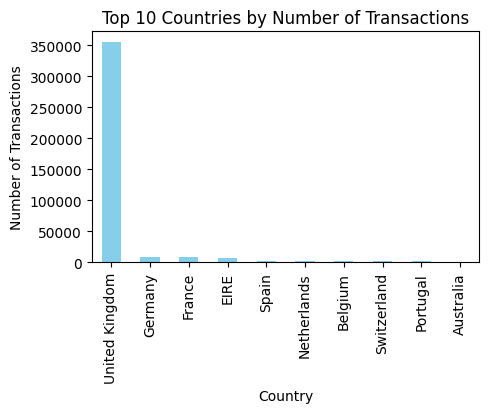

In [25]:
#data visualization
# 1. Country distribution (top 10)
plt.figure(figsize=(5,3))
df['Country'].value_counts().head(10).plot(kind='bar', color="skyblue")
plt.title("Top 10 Countries by Number of Transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Country")
plt.show()

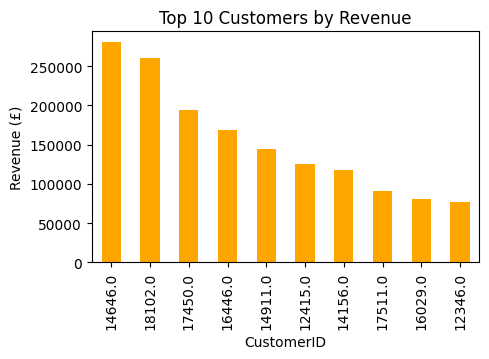

In [27]:
# 2. Top 10 customers by revenue
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(5,3))
top_customers.plot(kind='bar', color="orange")
plt.title("Top 10 Customers by Revenue")
plt.ylabel("Revenue (£)")
plt.xlabel("CustomerID")
plt.show()

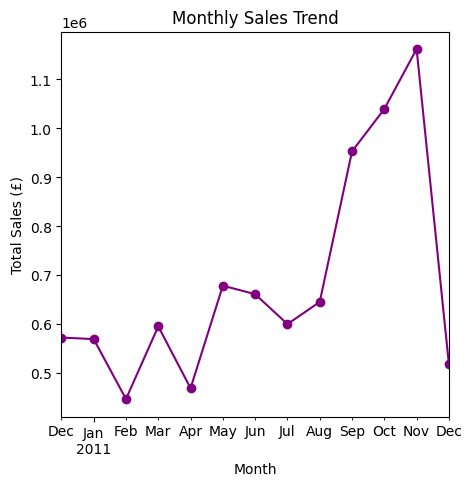

In [29]:
# 3. Monthly sales trend
monthly_sales = df.set_index('InvoiceDate')['TotalPrice'].resample('ME').sum()
plt.figure(figsize=(5,5))
monthly_sales.plot(marker='o', color="purple")
plt.title("Monthly Sales Trend")
plt.ylabel("Total Sales (£)")
plt.xlabel("Month")
plt.show()

## Feature Engineering
In this step, we are transforming raw transactional data into a monthly product-level dataset that can be used for forecasting.

 Step 1: Create Year-Month column → groups sales by month.

 Step 2: Aggregate features per product per month:

  - TotalQuantity (units sold)

  - Revenue (money earned)

  - InvoiceCount (number of transactions)

  - AvgPrice (average unit price)

Step 3: Add Lag Features → previous 1 month (Lag1), previous 2 months (Lag2) sales, to capture time dependency.
  
Step 4: Drop NaN rows caused by lagging.

Step 5: Visualization → plot sales trend of one product to verify lag features.

End result: a clean time-series dataset per product with features ready for machine learning forecasting.

In [31]:

# Step 1: Create Year-Month Column
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Step 2: Aggregate Sales Per Product Per Month
monthly_df = df.groupby(['StockCode','Description','YearMonth']).agg({
    'Quantity':'sum',        # total quantity sold
    'TotalPrice':'sum',      # total revenue
    'InvoiceNo':'nunique',   # number of unique transactions
    'UnitPrice':'mean'       # average price
}).reset_index()

monthly_df.rename(columns={
    'Quantity':'TotalQuantity',
    'TotalPrice':'Revenue',
    'InvoiceNo':'InvoiceCount',
    'UnitPrice':'AvgPrice'
}, inplace=True)

print(" Monthly Product-Level Dataset Shape:", monthly_df.shape)
print("\n First 5 Rows:")
print(monthly_df.head())

 Monthly Product-Level Dataset Shape: (30759, 7)

 First 5 Rows:
  StockCode                  Description YearMonth  TotalQuantity  Revenue  \
0     10002  INFLATABLE POLITICAL GLOBE    2010-12            224   190.40   
1     10002  INFLATABLE POLITICAL GLOBE    2011-01            337   286.45   
2     10002  INFLATABLE POLITICAL GLOBE    2011-02             50    42.50   
3     10002  INFLATABLE POLITICAL GLOBE    2011-03             23    19.55   
4     10002  INFLATABLE POLITICAL GLOBE    2011-04            189   160.65   

   InvoiceCount  AvgPrice  
0            16      0.85  
1            18      0.85  
2             5      0.85  
3             5      0.85  
4             5      0.85  


In [33]:
# =============================
# Step 3: Create Lag Features
# =============================
# Lag1 = Previous month's sales
# Lag2 = Sales from 2 months ago
monthly_df['Lag1'] = monthly_df.groupby('StockCode')['TotalQuantity'].shift(1)
monthly_df['Lag2'] = monthly_df.groupby('StockCode')['TotalQuantity'].shift(2)

# Drop rows where lag features are NaN (first months of each product)
monthly_df.dropna(inplace=True)

print("\n After Adding Lag Features:")
print(monthly_df.head())


 After Adding Lag Features:
  StockCode                  Description YearMonth  TotalQuantity  Revenue  \
2     10002  INFLATABLE POLITICAL GLOBE    2011-02             50    42.50   
3     10002  INFLATABLE POLITICAL GLOBE    2011-03             23    19.55   
4     10002  INFLATABLE POLITICAL GLOBE    2011-04            189   160.65   
7     10080     GROOVY CACTUS INFLATABLE   2011-07             24     9.36   
8     10080     GROOVY CACTUS INFLATABLE   2011-08             60    23.40   

   InvoiceCount  AvgPrice   Lag1   Lag2  
2             5      0.85  337.0  224.0  
3             5      0.85   50.0  337.0  
4             5      0.85   23.0   50.0  
7             2      0.39   48.0    2.0  
8             4      0.39   24.0   48.0  


In [35]:
# =============================
#  Step 4: Visualization (Sample Product)
# =============================

# Pick one sample product and visualize actual sales vs lag features
sample_product = monthly_df[monthly_df['StockCode'] == monthly_df['StockCode'].iloc[0]]

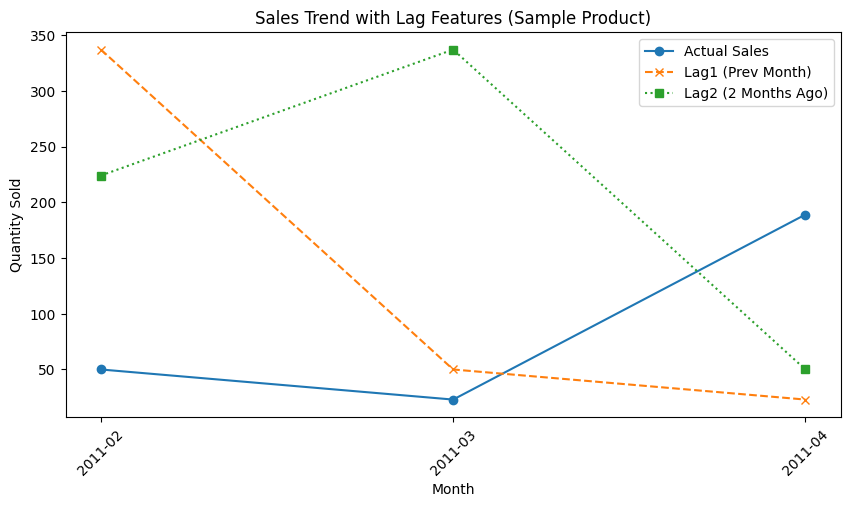

In [37]:
plt.figure(figsize=(10,5))
plt.plot(sample_product['YearMonth'].astype(str), sample_product['TotalQuantity'], marker='o', label='Actual Sales')
plt.plot(sample_product['YearMonth'].astype(str), sample_product['Lag1'], marker='x', linestyle='--', label='Lag1 (Prev Month)')
plt.plot(sample_product['YearMonth'].astype(str), sample_product['Lag2'], marker='s', linestyle=':', label='Lag2 (2 Months Ago)')
plt.xticks(rotation=45)
plt.title("Sales Trend with Lag Features (Sample Product)")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

# Demand Forecasting using Random Forest  

## 🔹 Steps Followed  

1. **Feature Selection**  
   - Input features:  
     - `Lag1` → Previous month’s sales  
     - `Lag2` → Sales from two months ago  
     - `Revenue` → Total revenue per product per month  
     - `InvoiceCount` → Number of unique invoices  
     - `AvgPrice` → Average price of the product  
   - Target variable:  
     - `TotalQuantity` (future sales to be predicted)  

---

2. **Train-Test Split (Time-Based)**  
   - Data sorted by `YearMonth`  
   - **Training set** → All months before **Nov 2011**  
   - **Testing set** → **Nov 2011 – Dec 2011**  
   - This simulates real-world forecasting where we train on past and predict the future.  

---

3. **Model Training (Random Forest Regressor )**  
   - Ensemble model with 100 trees (`n_estimators=100`)  
   - Handles **non-linear patterns** and interactions between features.  

---

4. **Prediction & Evaluation**  
   - Predicted demand for the test period.  
   - Metrics used:  
     -  **RMSE (Root Mean Squared Error)** → average prediction error  
     -  **MAE (Mean Absolute Error)** → absolute difference between predicted and actual values  
     - **R² Score** → how much variance in sales is explained by the model  

---

5. **Visualization**  
   - Scatter plot of **Actual vs Predicted Sales**  
   - Perfect predictions lie on the red dashed line → closer points = better model performance.  


Model Performance (Random Forest Regressor)
RMSE: 91.40154278777591
MAE: 12.164385038038883
R² Score: 0.934650115276363
Accuracy : 93.47%


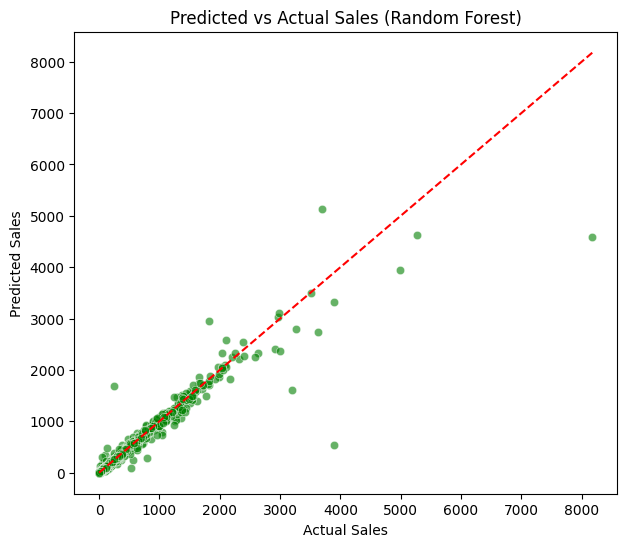

In [48]:
# =============================
#  Random Forest Regression
# =============================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 1: Features and Target
# -----------------------------
X = monthly_df[['Lag1','Lag2','Revenue','InvoiceCount',"AvgPrice"]]
y = monthly_df['TotalQuantity']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# Step 2: Train Random Forest Model
# -----------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,   # number of trees
    max_depth=None,    # no depth limit
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# -----------------------------
# Step 3: Predictions
# -----------------------------
y_pred = rf_model.predict(X_test)

# -----------------------------
# Step 4: Evaluation Metrics
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Accuracy-style metrics
accuracy_r2 = r2 * 100
#accuracy_mae = (1 - (mae / np.mean(y_test))) * 100

print("Model Performance (Random Forest Regressor)")
print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)
print(f"Accuracy : {accuracy_r2:.2f}%")

# -----------------------------
# Step 5: Predicted vs Actual Plot
# -----------------------------
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales (Random Forest)")
plt.show()


# Future Work & Expected Results

Now that we have successfully preprocessed the dataset, engineered features, and built an 
XGBoost regression model to forecast product demand, the next steps of the project will focus 
on extending the analysis and delivering richer insights.  

##  Future Work
-  **Advanced Feature Engineering**  
  - Add rolling averages (e.g., 3-month moving average).  
  - Include seasonal indicators (month, quarter, holidays).  

-  **Model Improvements**  
  - Hyperparameter tuning for XGBoost.  
  - Try other models like LightGBM, Prophet, or LSTM (deep learning for time series).  

-  **Popularity Classification**  
  - Convert forecasted demand into labels (Popular / Not Popular) using a demand threshold.  
  - Evaluate using Accuracy, Precision, Recall, F1-Score.  

-  **Visualization & Insights**  
  - Actual vs Predicted sales trends over time.  
  - Feature importance plots (which factors drive sales).  
  - Highlight Top-N products predicted to be most popular in the next period.  

-  **(Optional) Deployment**  
  - Build a Streamlit dashboard where users can upload data and see demand forecasts.  

##  Expected Results
- More accurate demand forecasting with lower RMSE and higher R².  
- Business-friendly popularity labels to identify top-selling products.  
- Clear visualizations of trends, forecasts, and product rankings.  
- A decision-support system that helps businesses optimize **inventory management** 
  and **marketing strategies**.
